## Analyze model predictions from latent code using PCA, tSNE, and UMAP
---
*Last edited 23 Oct 2025 by K. Wolcott*

In [1]:
# Read in data from latent codes for training attempt
import os, re, json, torch, numpy as np, pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# Specify training directory that contains config.json, latent_codes/, and model/
train_dir = 'run_v38' # TO DO: Update to relevant training attempt directory
os.chdir(train_dir)

# Specify model ckpt to use
CKPT = '3000' # TO DO: Choose the ckpt value you want to analyze results for

# Load config
config_path = 'model_params_config.json'
try:
    with open(config_path, 'r') as f:
        cfg = json.load(f)
    print(f"\033[92mLoaded config from {config_path}\033[0m")
except FileNotFoundError:
    print(f"\033[31mError: model_params_config.json not found in {config_path}. Exiting.\033[0m")

# Get training paths from config
train_paths = cfg['list_mesh_paths']
all_vtk_files = [os.path.basename(f) for f in train_paths]

# Parse species and vertebra info from filenames (e.g. "H-capensis-22-L8.ply_align.vtk").
pat = re.compile(r"^(?P<species>[\w\s\-]+)[\-_ ]+\d+[\-_ ]+(?P<vertebra>[CTL]\d+)", re.IGNORECASE)
labels = []
unmatched_files = []
for f in all_vtk_files:
    fname = os.path.basename(f)
    m = pat.match(fname)
    if m:
        species = m.group("species").strip()
        vertebra = m.group("vertebra").strip()  # e.g. "C2", "L8"
        labels.append((species, vertebra))
    else:
        labels.append((None, None))
        unmatched_files.append(fname)

# Load latent codes from the single .pth file.
CKPT_PATH = 'latent_codes' + '/' + CKPT + '.pth'
latent_ckpt = torch.load(CKPT_PATH, map_location="cpu") 
codes = latent_ckpt['latent_codes']['weight'].detach().cpu().numpy()

Loaded config from model_params_config.json


/tmp/ipykernel_651154/1853091183.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_ckpt = torch.load(CKPT_PATH, map_location="cpu")


## Statistical analysis of model performance - PCA, tSNE, UMAP
---

In [2]:
# Define functions for plotting
import colorsys
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Get marker based on life history of species
def get_marker(species):
    species = species.lower()
    if "ouroborus" in species:  # bites tail to front
        return 'v' # triangle (down)
    elif any(k in species for k in ["chalcides", "tetradactylus", "chamaesaura"]):  # swims in grass
        return 'P' # plus filled
    elif any(k in species for k in ["skoog", "eremiascincus", "_scincus"]): # swims in sand
        return '+'  # plus regular
    elif any(k in species for k in ["acontias", "mochlus", "rhineura", "dibamus", "lanthonotus", "bipes", "diplometopon", "pseudopus"]):  # burrowing
        return 's'  # square
    elif any(k in species for k in ["jonesi", "corucia", "gecko", "chamaeleo", "iguana", "brookesia", "dracaena", "anolis", "basiliscus", 
                                    "dracaena", "aristelliger", "sceloporus", "lialis", "phyllurus"]):  # arboreal
        return 'd' # thin diamond
    elif any(k in species for k in ["elgaria", "smaug_giganteus", "broadleysaurus", "ateuchosaurus", "alopoglossus", "heloderma", "tupinambis",
                                    "carlia", "lipinia", "tiliqua", "tribolonotus", "leiolepis", "eublepharis", "oreosaurus", "baranus",
                                    "callopistes", "cricosaura", "lepidophyma", "sphenodon", "lacerta", "enyaloides", "crocodilurus"]):  # terrestrial
        return 'X' # x filled
    elif any(k in species for k in ["eryx", "homalopsis", "aniolios"]):   # snake
        return '2' #
    else:                      # saxicolous/rock dwelling
        return 'o'  # circle (default)
    
# Make a reference legend for marker symbols
# Define markers and their corresponding life history strategy labels
legend_items = [
    ('v', 'Bites tail to side'),
    ('P', 'Grass swimmer'),
    ('+', 'Sand swimmer'),
    ('s', 'Burrowers'),
    ('d', 'Arboreal'),
    ('X', 'Terrestrial'),
    ('o', 'Saxicolous'),
    ('2', 'Snake')
]

# Function to plot the legend for life history strategies
def plot_life_history_legend(legend_items, title='Symbol Key for Species Life History Strategies', outfpath=None):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    # Plot dummy points for the legend
    for i, (marker, label) in enumerate(legend_items):
        ax.plot([], [], marker=marker, linestyle='None', markersize=10, label=label, color='black')
    # Customize and display the legend
    ax.legend(loc='center left', frameon=False)
    ax.axis('off')
    plt.title(title)
    plt.tight_layout()
    # Save the plot if an output file path is provided
    if outfpath:
        plt.savefig(outfpath, dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()

# Function to generate the legend for family colors
def plot_family_color_legend(family_colors):
    # Create a list of patches and labels for the legend
    patches = []
    labels = []
    for family, color in family_colors.items():
        patch = mpatches.Patch(color=color, label=family)
        patches.append(patch)
        labels.append(family)
    # Create the legend
    plt.figure(figsize=(8, 6))
    plt.legend(handles=patches, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Family Colors")
    plt.axis('off')  # Turn off the axis since we only want the legend
    plt.show()
    
# Define a sort key that orders vertebrae by region (C < T < L) then by the numeric part.
def sort_key(item):
    region_order = {'C': 0, 'T': 1, 'L': 2}
    v = item[0]
    return (region_order.get(v[0], 99), int(v[1:]))

# Get family name for coloring scheme
def extract_family(species_label):
    family = species_label.split('_')[0]
    species_label = species_label.lower()
    
    if any(k in species_label for k in ["scincus", "scincidae"]):
        family = "Scincidae"
    elif "ouroborus" in species_label:
        family = "Cordylidae_Ouroborus"
    elif any(k in species_label for k in ["gerrhosaurus", "gerrho"]):
        family = "Gerrhosauridae"
    elif any(k in species_label for k in ["chameleo", "iguana", "agamidae", "anolidae", "corytophanidae", 
                                          "crotaphytidae", "hoplocercidae", "leiocephalidae", "leiosauridae",
                                          "phrynosomatidae", "tropiduridae"]):
        family = "Iguania"
    elif any(k in species_label for k in ["anguidae", "lanthonotus", "varanus", "shinosaurus", "heloderma"]):
        family = "Anguimorpha"
    elif any(k in species_label for k in  ["lacertidae", "lacerta"]):
        family = "Lacertidae" 
    elif any(k in species_label for k in  ["bipes", "rhineura", "diplometopon"]):
        family = "Amphisbaenea"
    elif any(k in species_label for k in  ["gecko", "tarentola", "eublepharis", "aristelliger", "phyllurus", "lialis"]):
        family = "Gekkota"    
    elif any(k in species_label for k in ["eryx", "homalopsis", "aniolios"]):
        family = "Snake"
    elif "xantusiidae" in species_label:
        family = "Xantusiidae"
    elif any(k in species_label for k in ["gymnopthalmidae", "teiidae"]):
        family = "Gymnophthalmoidea"
    elif "dibamus" in species_label:
        family = "Dibamidae"
    elif "sphenodon" in species_label:
        family = "Rhynchocephalia"
    
    return family

# Create a colormap for unique families
def make_family_cmap(families):
    default_col =  np.array([0.52, 0.52, 0.52])  # grey
    family_base_colors = {
        "iguania": np.array([0.78, 0.16, 0.16]),  # auburn
        "anguimorpha": np.array([1.00, 0.79, 0.20]),  # saffron
        "cordylidae": np.array([0.10, 0.51, 0.40]),  # dark teal
        "cordylidae_ouroborus": np.array([0.082, 0.76, 0.92]),  # turquoise - blue
        "gekkota": np.array([0.41, 0.227, 0.6]),  # dark lilac
        "gymnophthalmoidea": np.array([0.73, 0.14, 0.5]),  # dark hot pink
        "gerrhosauridae": np.array([0.98, 0.39, 0.14]),  # orange
        "scincidae": np.array([0.65, 0.69, 0.12]),  # apple green
        "amphisbaenea": np.array([0.60, 0.50, 0.46]),  # warm slate
        "lacertidae": np.array([0.145, 0.39, 0.075]),  # forest green
        "xantusiidae": np.array([0.88, 0.74, 0.59])  # emoji white
    }
    # Normalize family names to lowercase to handle case-insensitive comparison
    family_colors = {}
    for family in families:
        family_lower = family.lower()  # Convert input family name to lowercase
        family_colors[family] = family_base_colors.get(family_lower, default_col)
    return family_colors

# Add a gradient by species within family
def generate_species_cmap_gradient(family_base_colors, species_groups, max_shift=0.4):
    species_colors = {}
    family_species_map = defaultdict(list)
    # Group species by family
    for species in species_groups:
        family = extract_family(species)
        family_species_map[family].append(species)
    for family, species_list in family_species_map.items():
        base_rgb = family_base_colors.get(family, np.array([0.7, 0.7, 0.7]))  # fallback: gray
        base_hls = colorsys.rgb_to_hls(*base_rgb)
        sorted_species = sorted(species_list)
        n = len(sorted_species)
        center_idx = n // 2
        for i, sp in enumerate(sorted_species):
            if i == center_idx:
                # Middle species gets base color
                new_rgb = base_rgb
            else:
                # Shift lightness slightly (lighter or darker)
                shift_direction = -1 if i < center_idx else 1
                shift_amount = (abs(i - center_idx) / (n - 1)) * max_shift
                new_lightness = np.clip(base_hls[1] + shift_direction * shift_amount, 0, 1)
                new_rgb = colorsys.hls_to_rgb(base_hls[0], new_lightness, base_hls[2])
            species_colors[sp] = tuple(np.clip(new_rgb, 0, 1)) + (1.0,)  # Add alpha channel
    return species_colors

### PCA

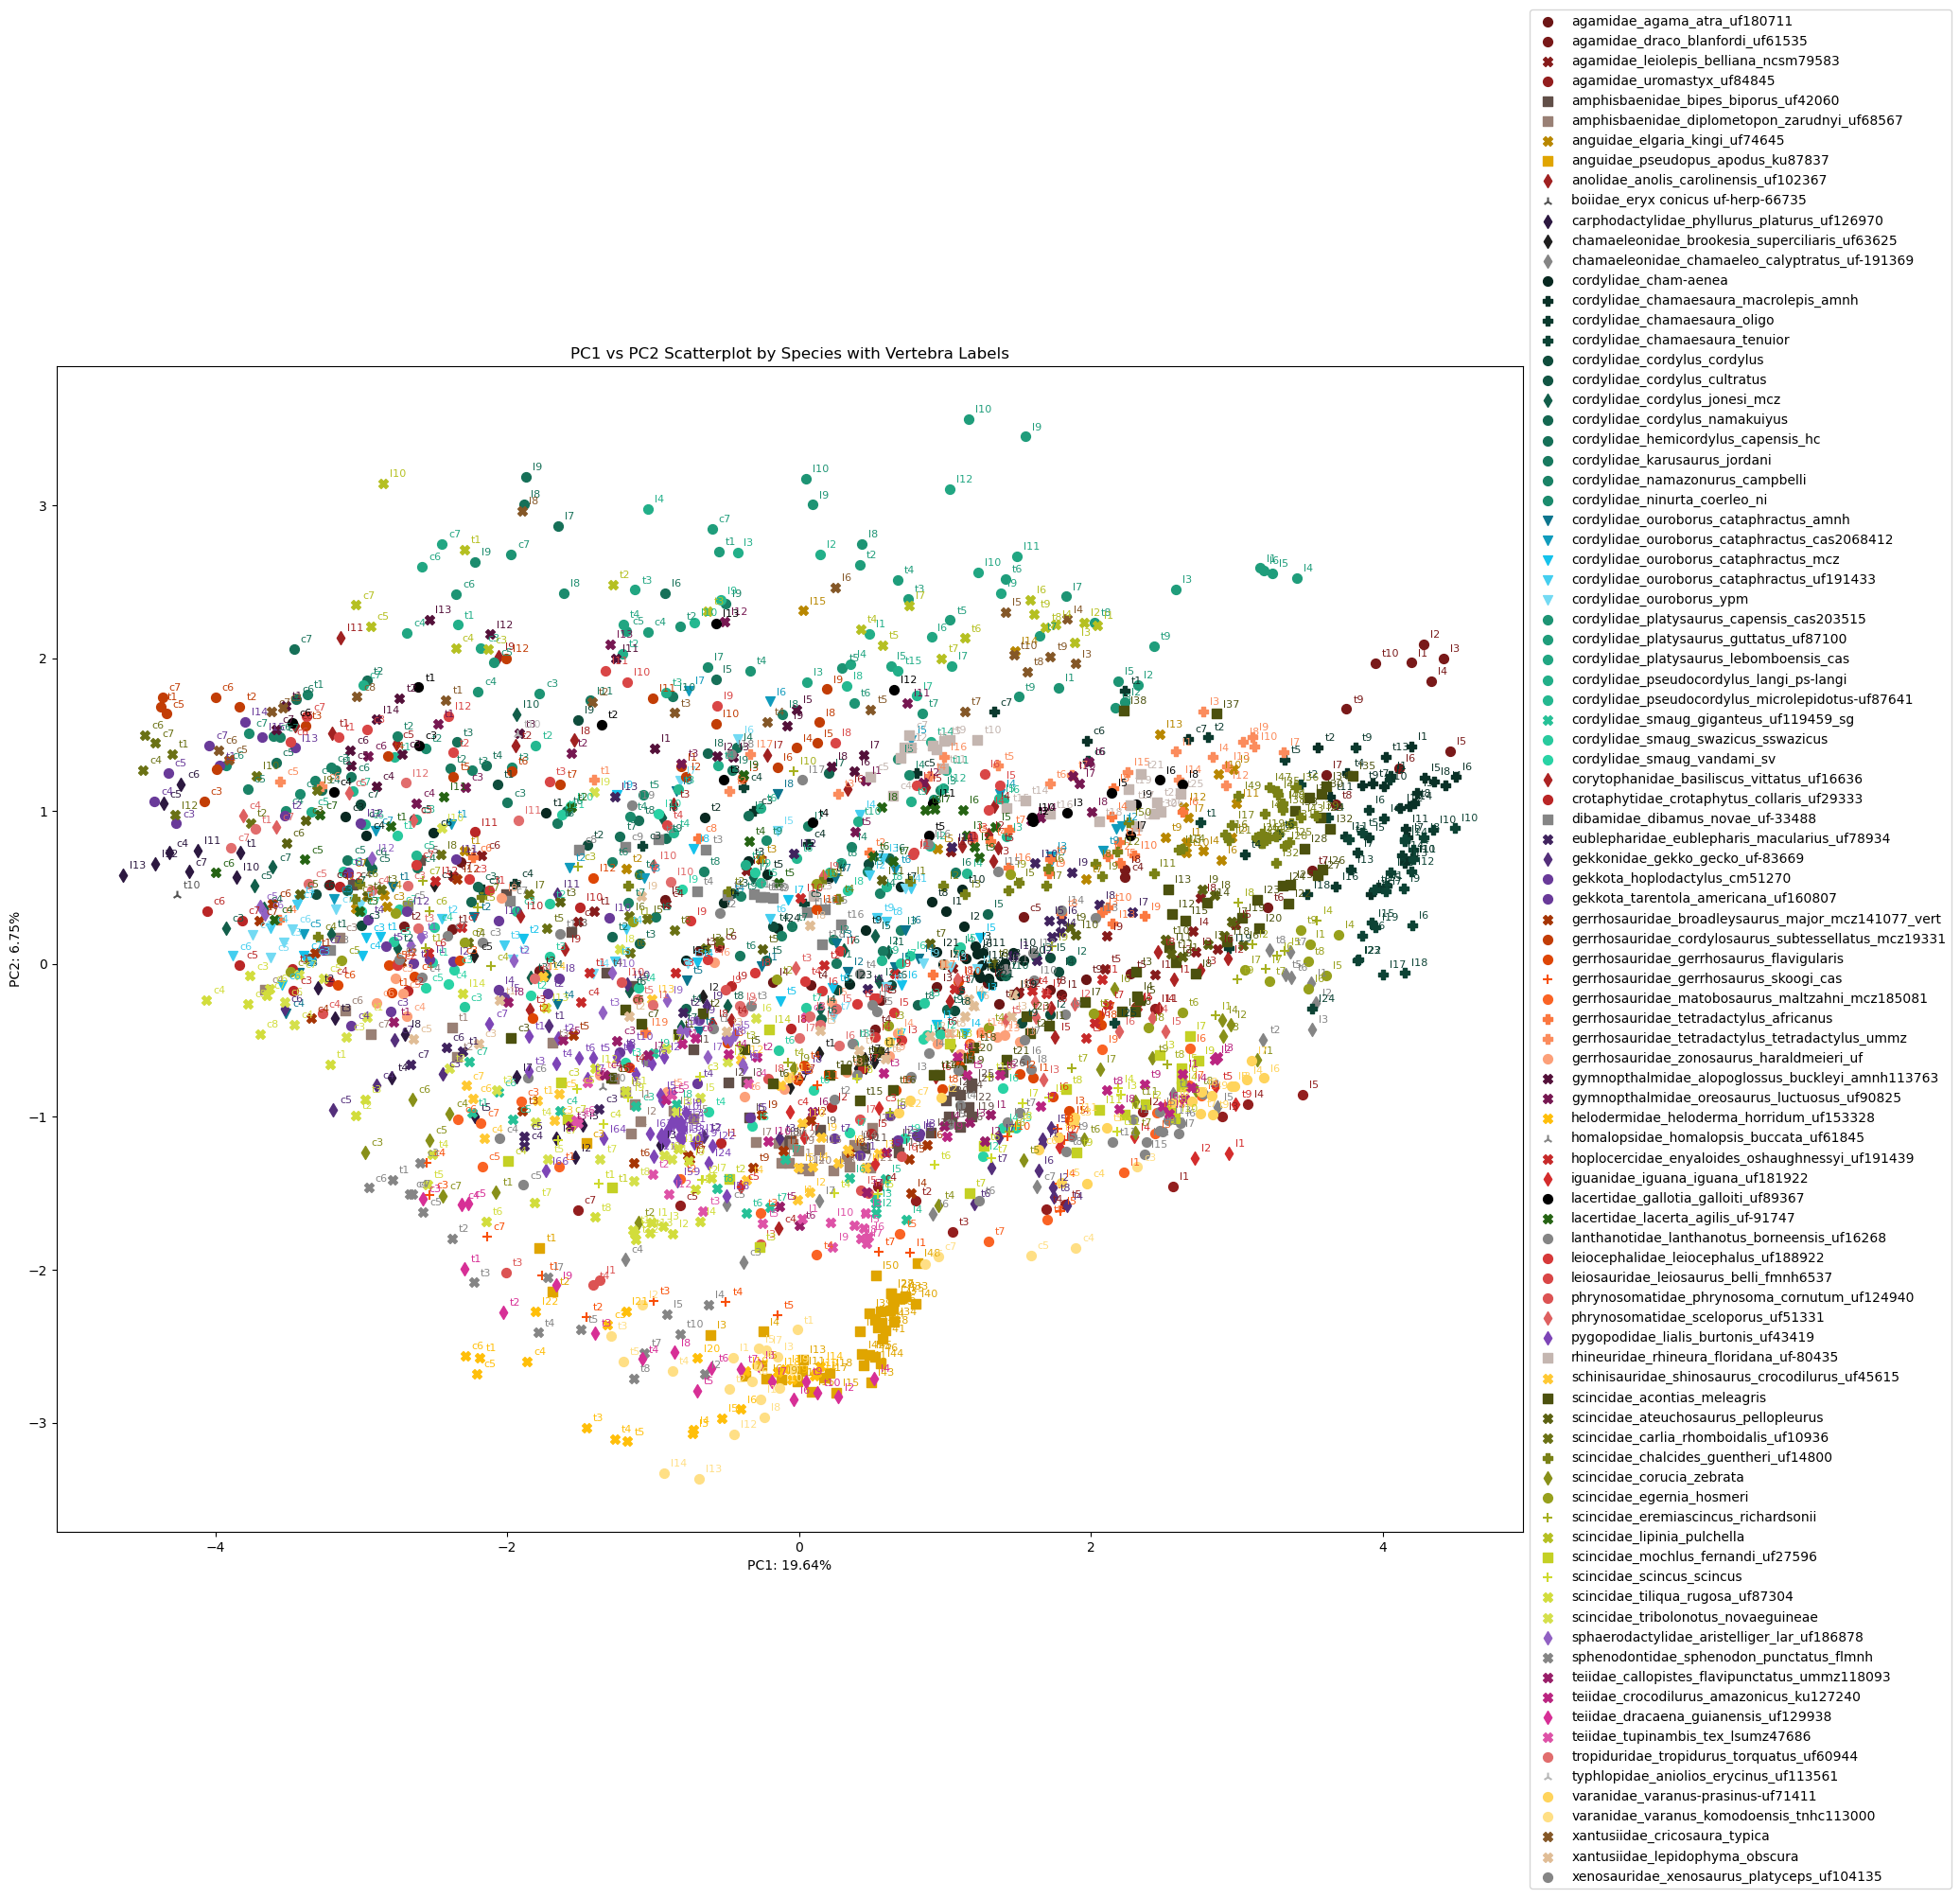

In [3]:
# PCA 1 v 2

# Run PCA to reduce dimensions (using PC1 and PC2 for the scatterplot).
pca = PCA(n_components=4)
pca_coords = pca.fit_transform(codes)

# Group PC1 and PC2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, pca_coords[i, 0], pca_coords[i, 1]))

# Create a colormap for unique families
families = sorted({extract_family(sp) for sp in species_groups.keys()})
family_base_colors = make_family_cmap(families)

# Add mapping for species colors based on family (gradient of light to dark)
species_colors = generate_species_cmap_gradient(family_base_colors, species_groups)

# Draw Plot
plt.figure(figsize=(20,16))
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    vertebra_labels, pc1_vals, pc2_vals = zip(*points_sorted)
    # Connect points with a dashed line.
    #plt.plot(pc1_vals, pc2_vals, '--', alpha=0.5, color=species_colors[species])
    # Scatter plot the points.
    plt.scatter(pc1_vals, pc2_vals, marker=get_marker(species), color=species_colors[species], label=species, s=50)
    # Annotate each point with its vertebra label.
    for x, y, label in zip(pc1_vals, pc2_vals, vertebra_labels):
        plt.annotate(label, (x, y), xytext=(5, 5),  # Offset in points (x, y)
                    textcoords='offset points', fontsize=8, color=species_colors[species])

plt.xlabel(f"PC1: {(pca.explained_variance_ratio_[0])*100:.2f}%")
plt.ylabel(f"PC2: {(pca.explained_variance_ratio_[1])*100:.2f}%")
plt.title("PC1 vs PC2 Scatterplot by Species with Vertebra Labels")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
outfpath = os.path.split(os.getcwd())[1] + '_pca_1v2.png'
plt.savefig(outfpath, dpi=300, bbox_inches='tight')
plt.show()

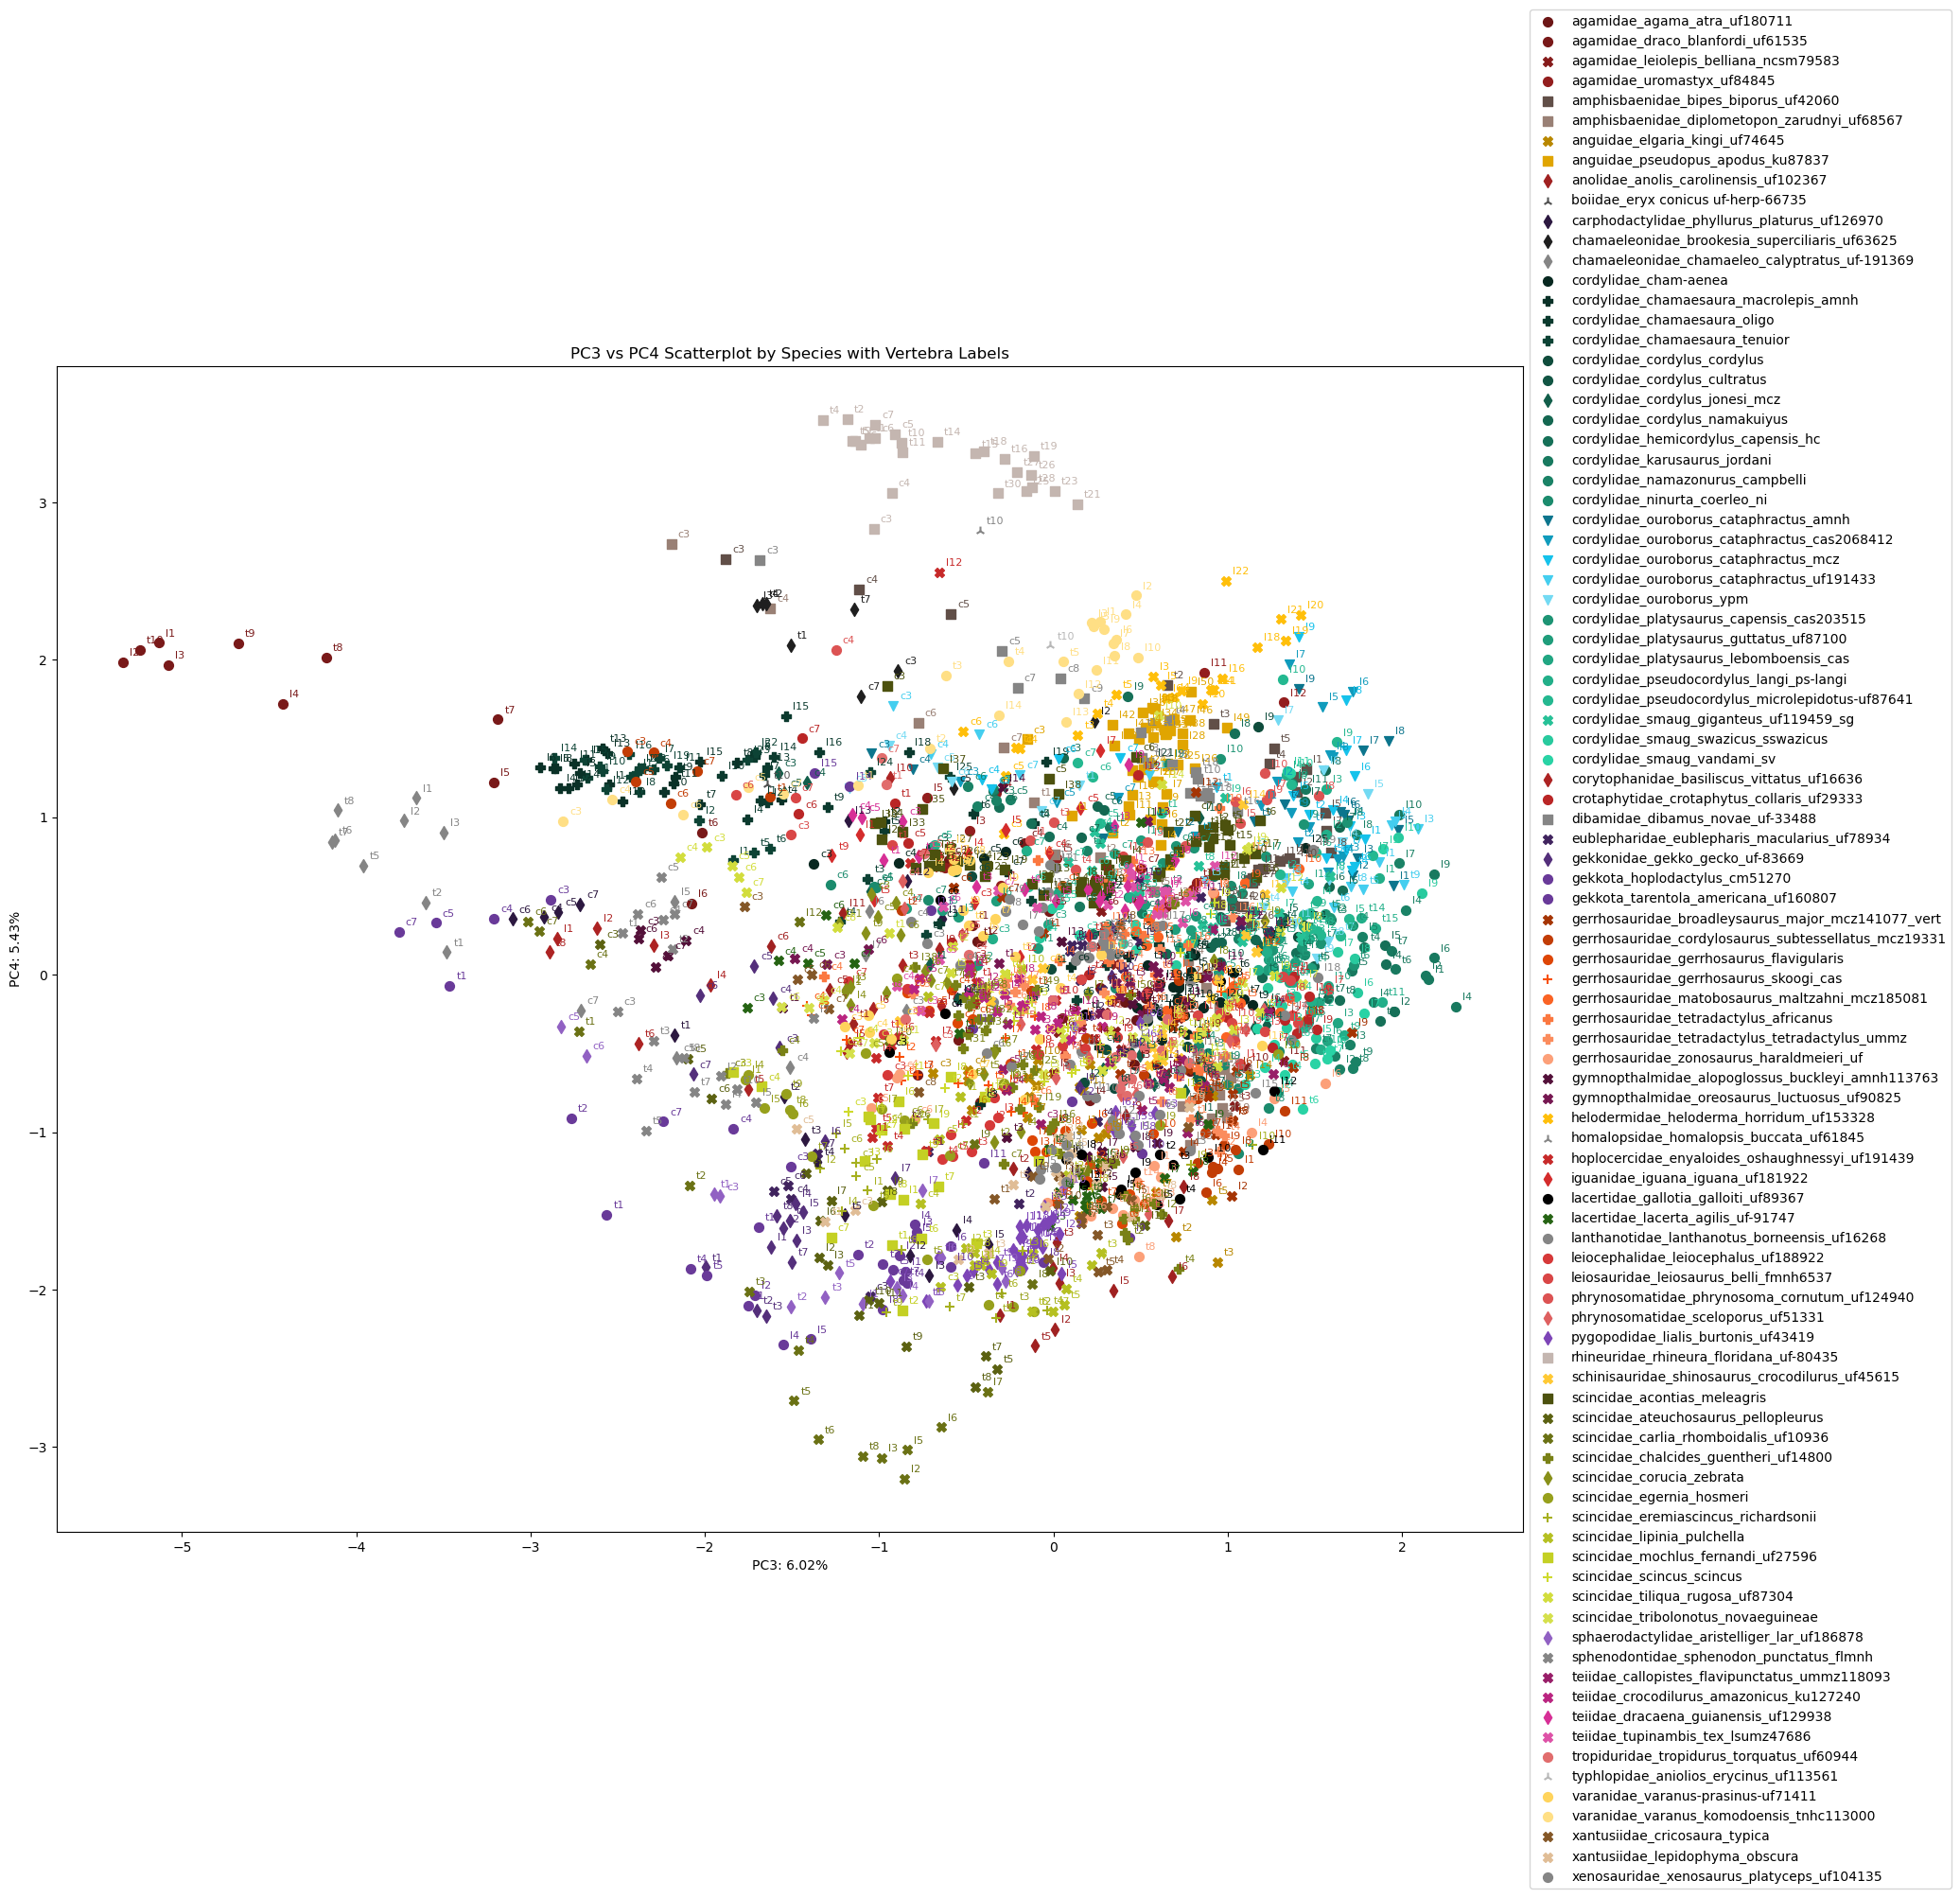

In [4]:
# PCA 3 v 4

# Group PC3 and PC4 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, pca_coords[i, 2], pca_coords[i, 3]))

# Create a colormap for unique families
families = sorted({extract_family(sp) for sp in species_groups.keys()})
family_base_colors = make_family_cmap(families)

# Add mapping for species colors based on family (gradient of light to dark)
species_colors = generate_species_cmap_gradient(family_base_colors, species_groups)

# Draw Plot
plt.figure(figsize=(20,16))
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    vertebra_labels, pc1_vals, pc2_vals = zip(*points_sorted)
    # Connect points with a dashed line.
    #plt.plot(pc1_vals, pc2_vals, '--', alpha=0.5, color=species_colors[species])
    # Scatter plot the points.
    plt.scatter(pc1_vals, pc2_vals, marker=get_marker(species), color=species_colors[species], label=species, s=50)
    # Annotate each point with its vertebra label.
    for x, y, label in zip(pc1_vals, pc2_vals, vertebra_labels):
        plt.annotate(label, (x, y), xytext=(5, 5),  # Offset in points (x, y)
                    textcoords='offset points', fontsize=8, color=species_colors[species])


plt.xlabel(f"PC3: {(pca.explained_variance_ratio_[2])*100:.2f}%")
plt.ylabel(f"PC4: {(pca.explained_variance_ratio_[3])*100:.2f}%")
plt.title("PC3 vs PC4 Scatterplot by Species with Vertebra Labels")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
outfpath = os.path.split(os.getcwd())[1] + '_pca_3v4.png'
plt.savefig(outfpath, dpi=300, bbox_inches='tight')
plt.show()

### t-SNE

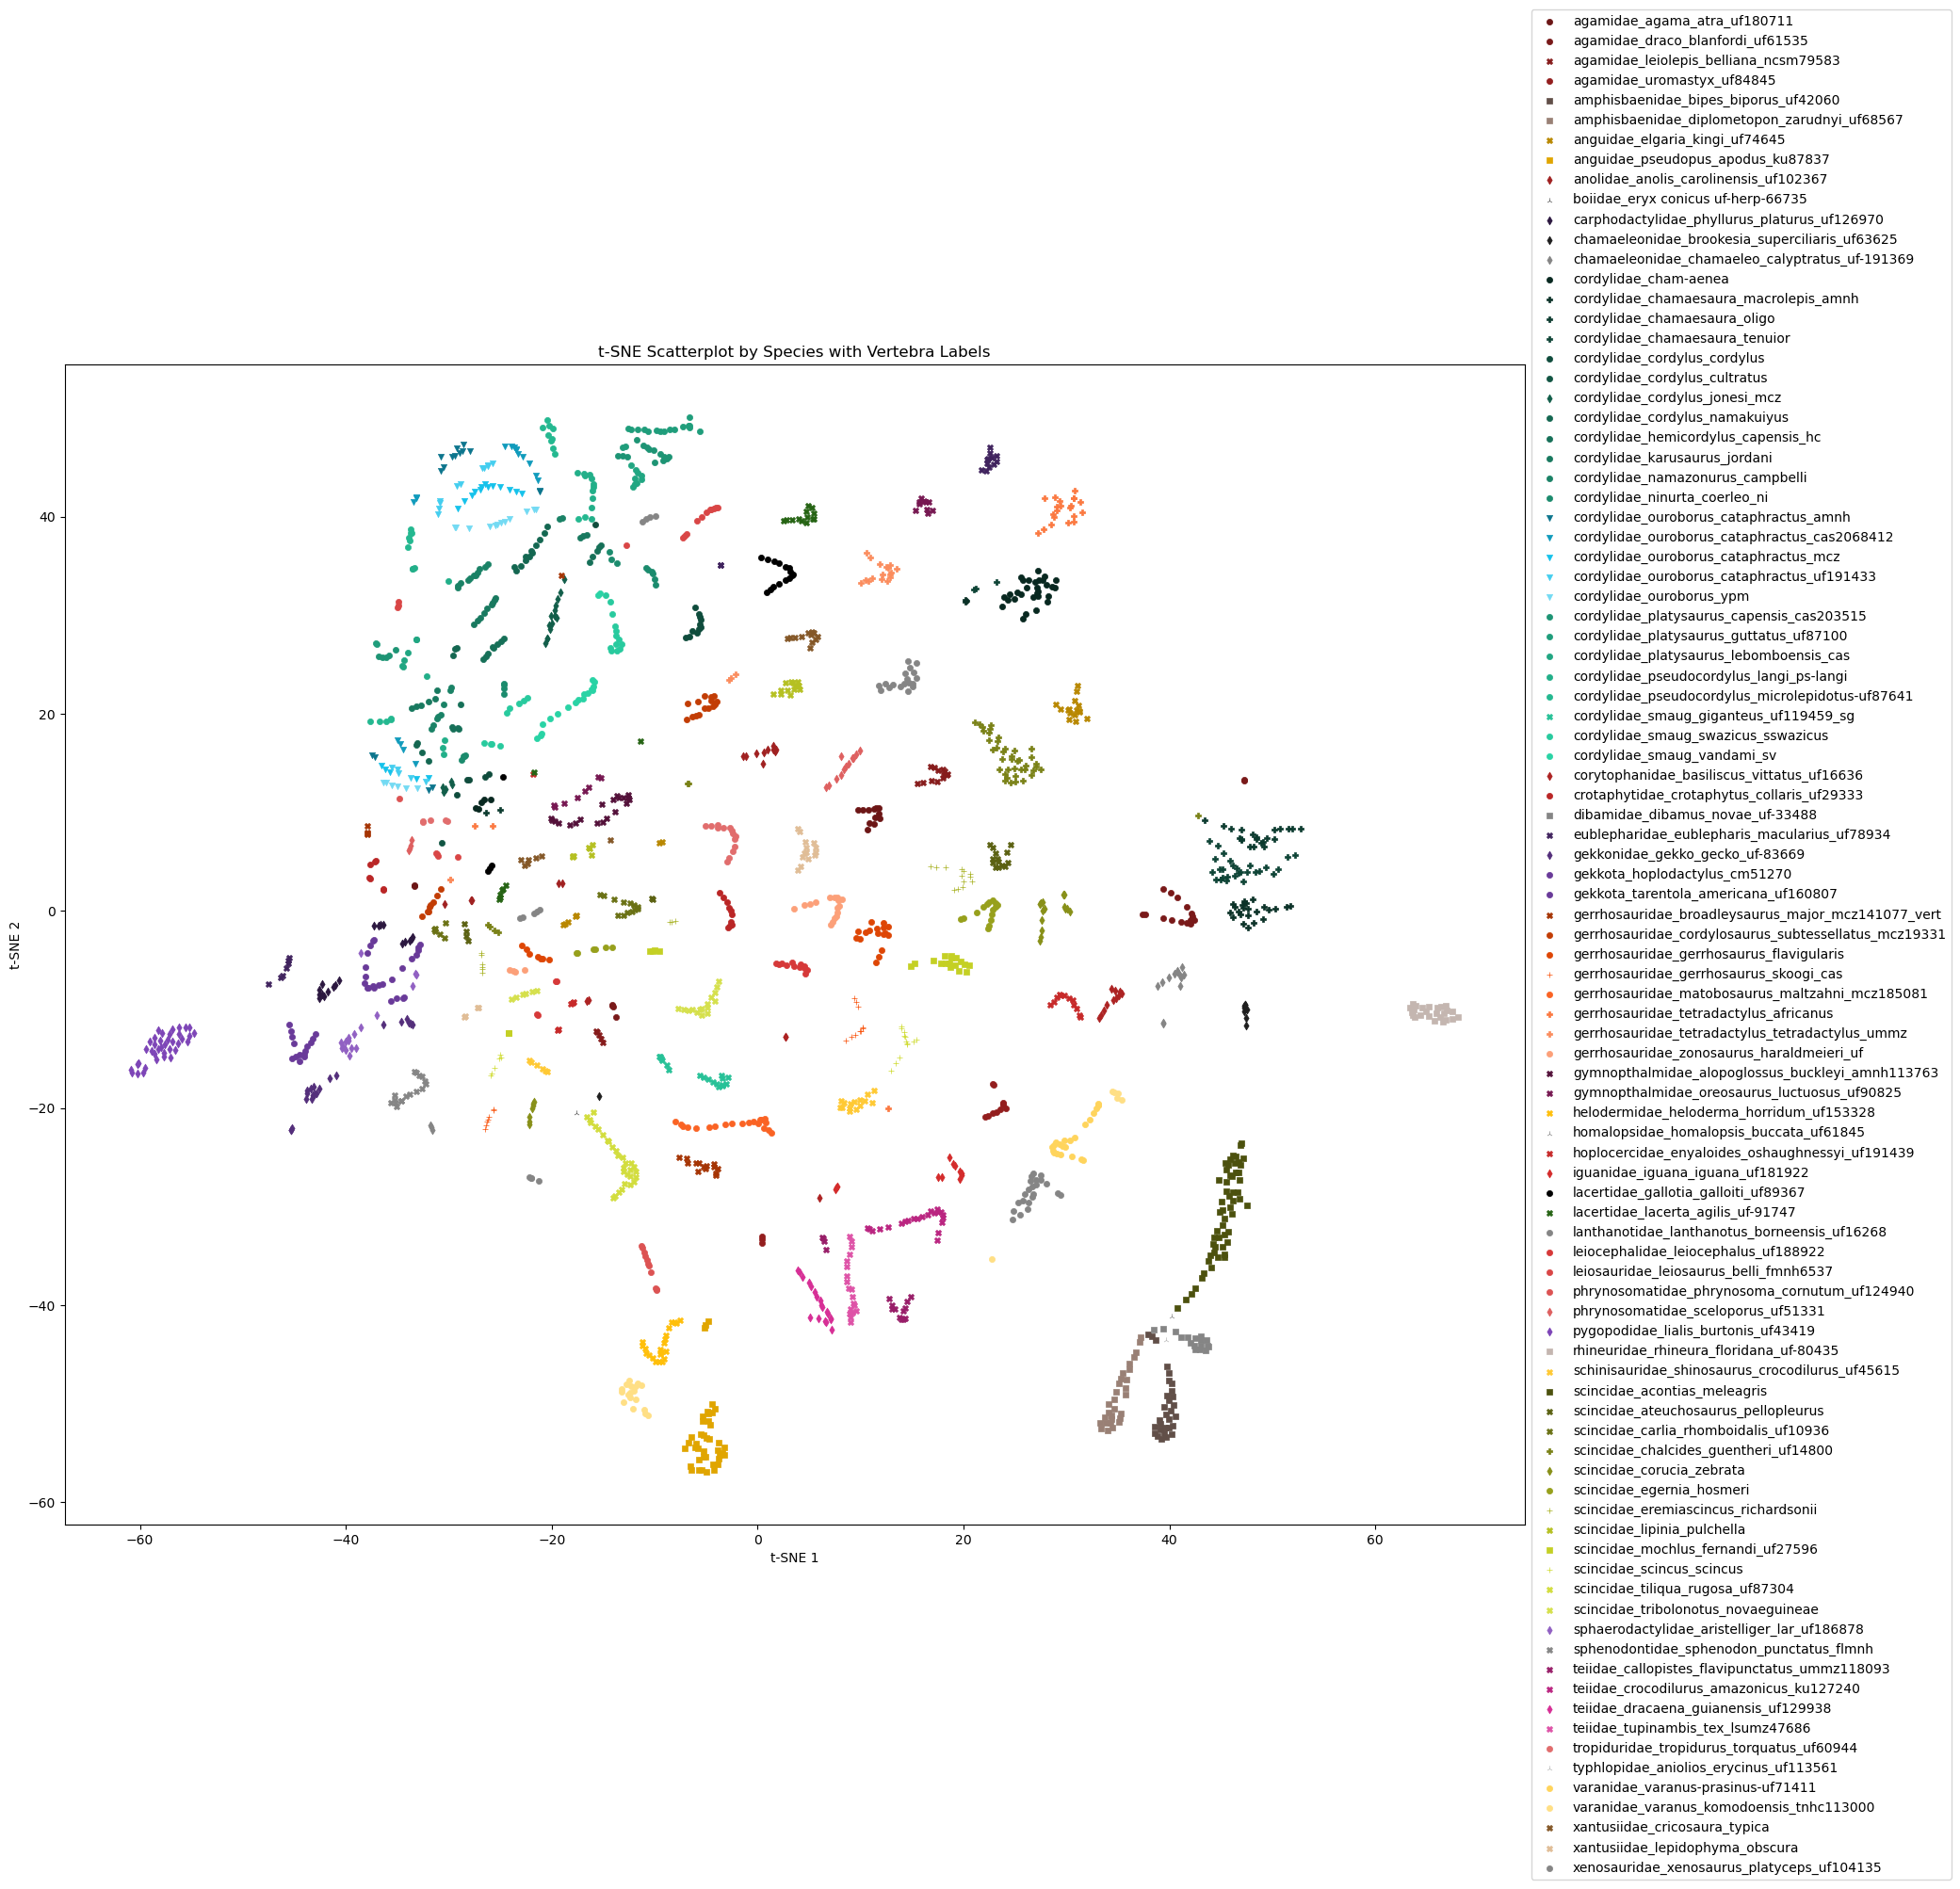

In [34]:
# t-SNE

# Run t-SNE to reduce dimensions
tsne = TSNE(n_components=2, 
            perplexity=30, 
            learning_rate=200,
            early_exaggeration=12,
            n_iter_without_progress=2000,
            metric="cosine",
            random_state=42)
tsne_coords = tsne.fit_transform(codes)

# Group t-SNE1 and t-SNE2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, tsne_coords[i, 0], tsne_coords[i, 1]))

# Create a colormap for unique families
families = sorted({extract_family(sp) for sp in species_groups.keys()})
family_base_colors = make_family_cmap(families)

# Add mapping for species colors based on family (gradient of light to dark)
species_colors = generate_species_cmap_gradient(family_base_colors, species_groups)

# Draw Plot
plt.figure(figsize=(20,16))
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    vertebra_labels, pc1_vals, pc2_vals = zip(*points_sorted)
    # Connect points with a dashed line.
    #plt.plot(pc1_vals, pc2_vals, '--', alpha=0.5, color=species_colors[species])
    # Scatter plot the points.
    plt.scatter(pc1_vals, pc2_vals, marker=get_marker(species), color=species_colors[species], label=species, s=20, linewidths=0.5)
    # Annotate each point with its vertebra label.
    #for x, y, label in zip(pc1_vals, pc2_vals, vertebra_labels):
        #plt.annotate(label, (x, y), xytext=(5, 5),  # Offset in points (x, y)
                    #textcoords='offset points', fontsize=8, color=species_colors[species])

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Scatterplot by Species with Vertebra Labels")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
outfpath = os.path.split(os.getcwd())[1] + '_tSNE.png'
plt.savefig(outfpath, dpi=300, bbox_inches='tight')
plt.show()

### UMAP

/home/k.wolcott/anaconda3/envs/NSM/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k.wolcott/anaconda3/envs/NSM/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


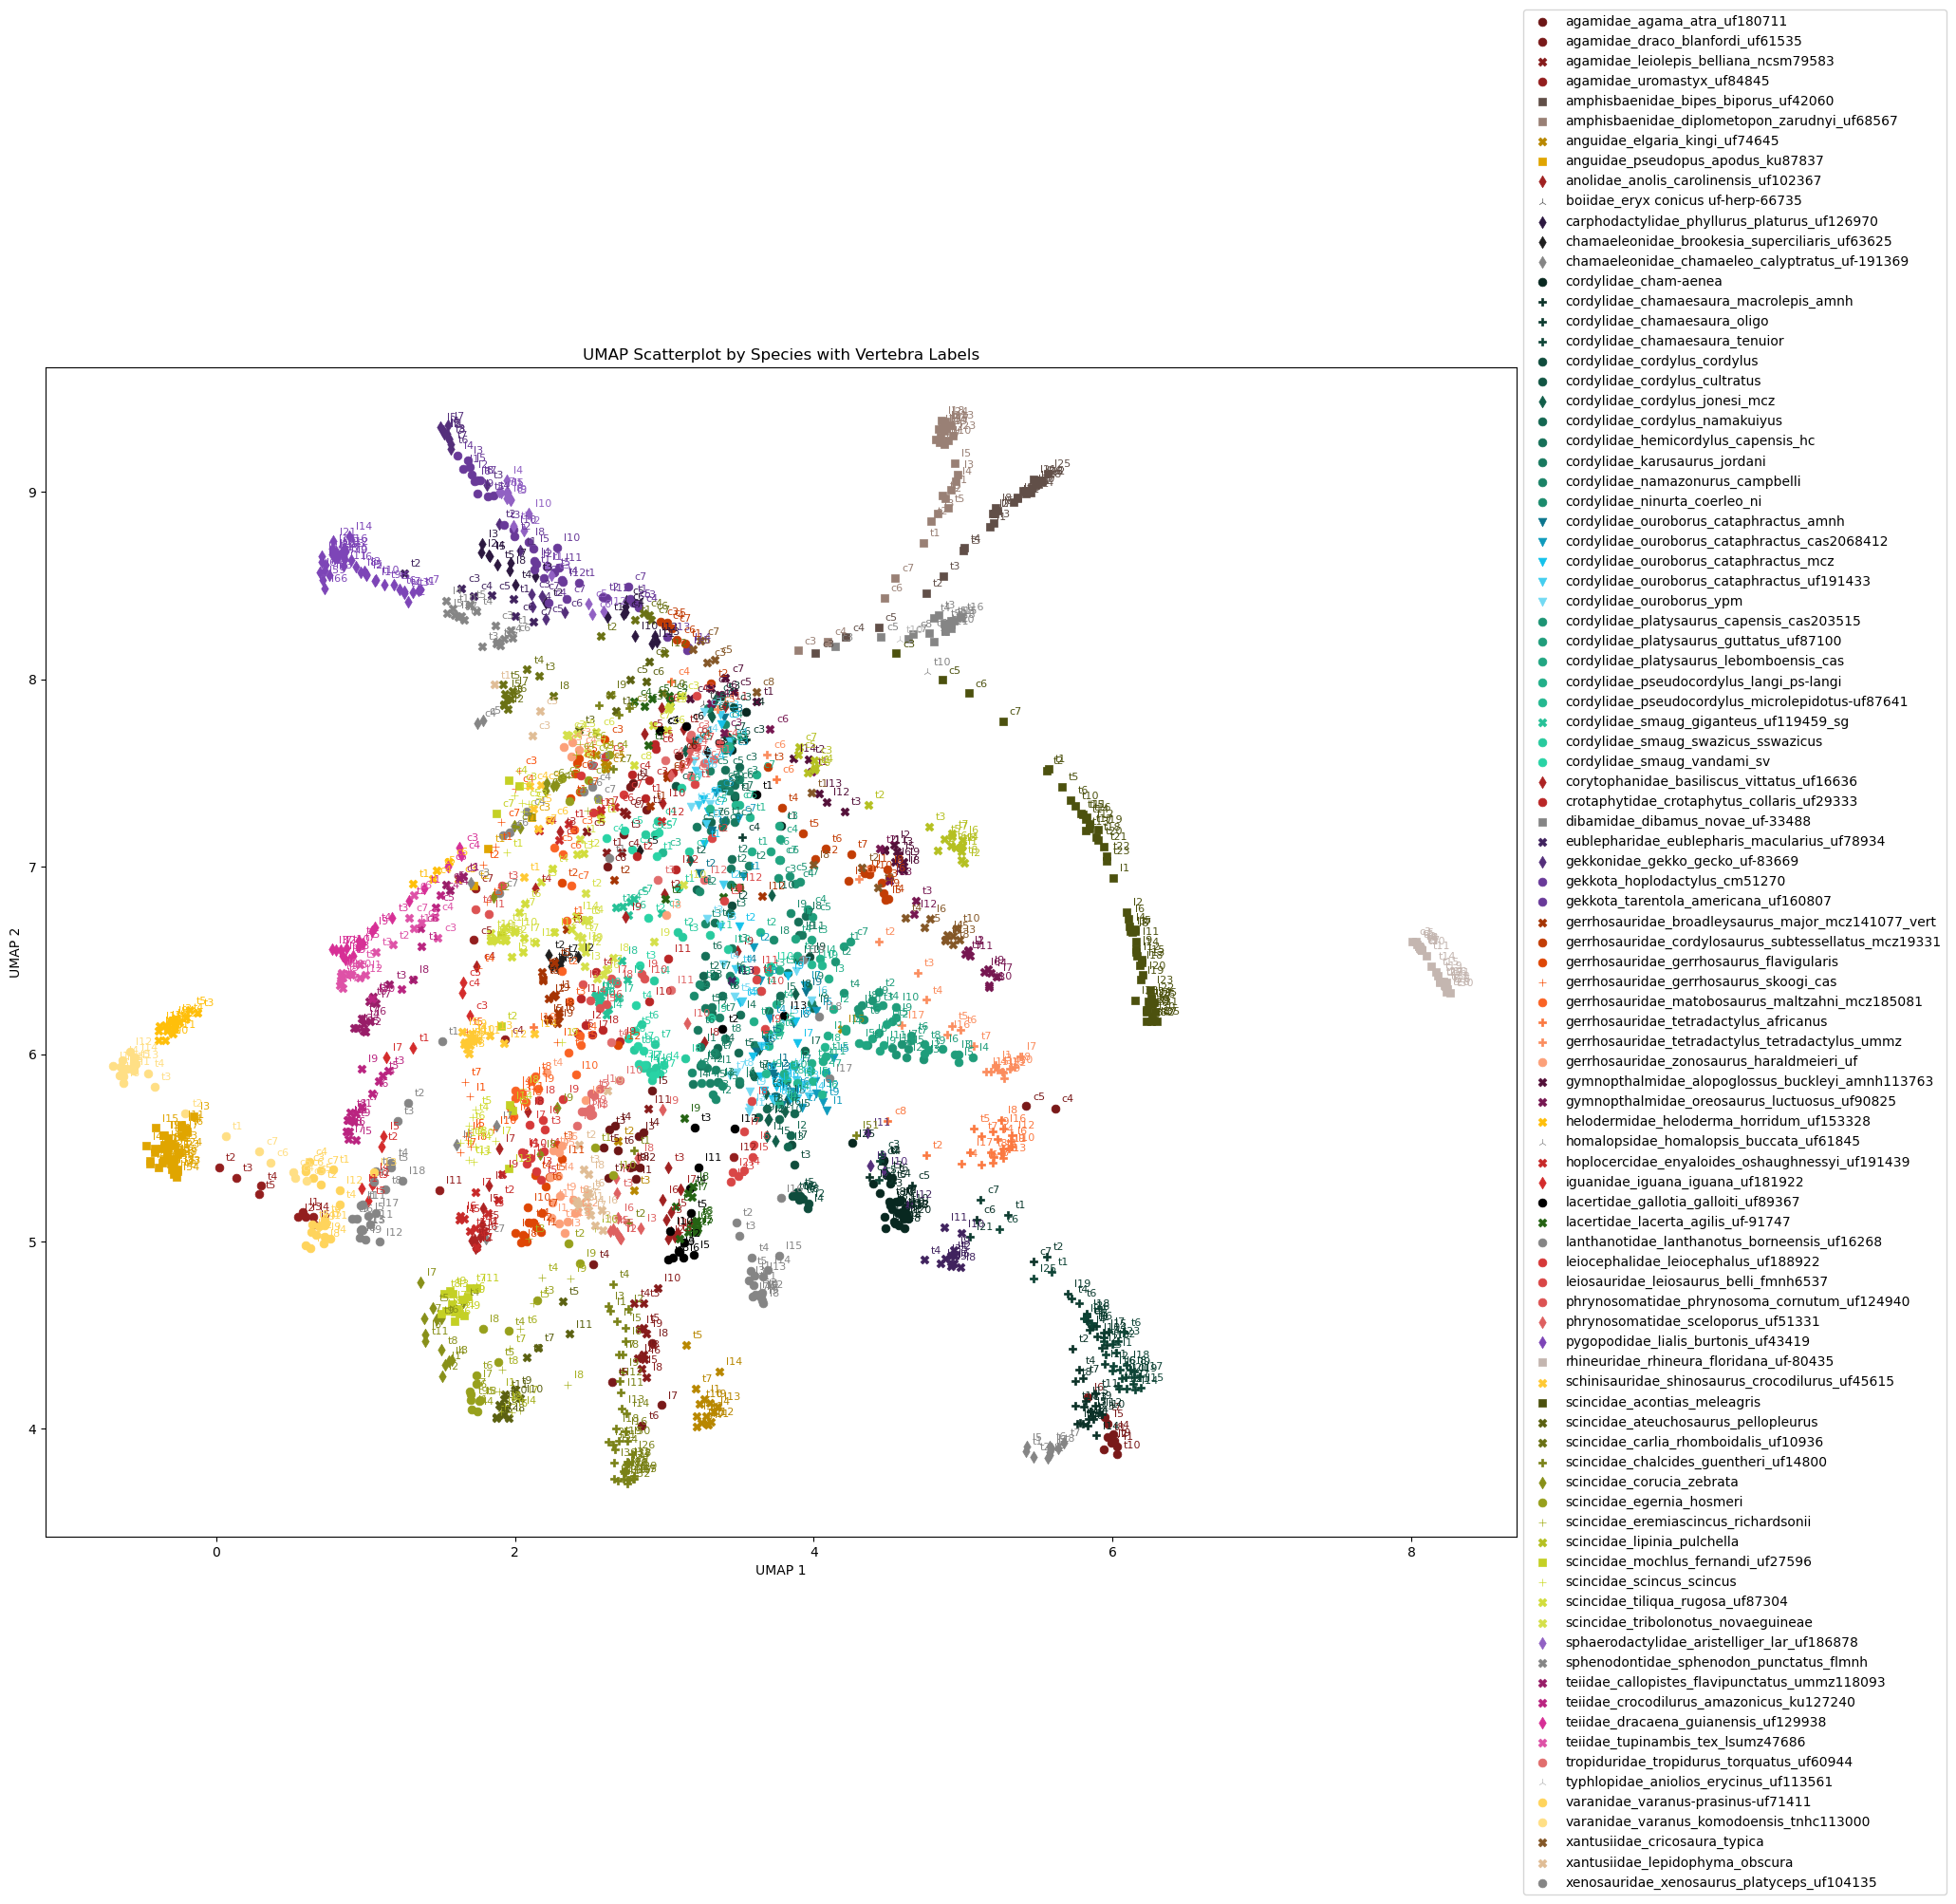

In [30]:
# Run UMAP to reduce dimensions (using UMAP1 and UMAP2 for the scatterplot).
umap_reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.2, spread=0.5, n_epochs=500, random_state=42)
#umap_coords = umap_reducer.fit_transform(codes)
pca = PCA(n_components=50)
codes_pca = pca.fit_transform(codes)
umap_coords = umap_reducer.fit_transform(codes_pca)

# Group PC1 and PC2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, umap_coords[i, 0], umap_coords[i, 1]))

# Create a colormap for unique families
families = sorted({extract_family(sp) for sp in species_groups.keys()})
family_base_colors = make_family_cmap(families)

# Add mapping for species colors based on family (gradient of light to dark)
species_colors = generate_species_cmap_gradient(family_base_colors, species_groups)

# Draw Plot
plt.figure(figsize=(20,16))
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    vertebra_labels, pc1_vals, pc2_vals = zip(*points_sorted)
    # Connect points with a dashed line.
    #plt.plot(pc1_vals, pc2_vals, '--', alpha=0.5, color=species_colors[species])
    # Scatter plot the points.
    plt.scatter(pc1_vals, pc2_vals, marker=get_marker(species), color=species_colors[species], label=species, s=40, linewidth=0.5)
    # Annotate each point with its vertebra label.
    for x, y, label in zip(pc1_vals, pc2_vals, vertebra_labels):
        plt.annotate(label, (x, y), xytext=(5, 5),  # Offset in points (x, y)
                    textcoords='offset points', fontsize=8, color=species_colors[species])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Scatterplot by Species with Vertebra Labels")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
outfpath = os.path.split(os.getcwd())[1] + '_UMAP.png'
plt.savefig(outfpath, dpi=300, bbox_inches='tight')
plt.show()

## Plot legends for family color pallet and symbols
---

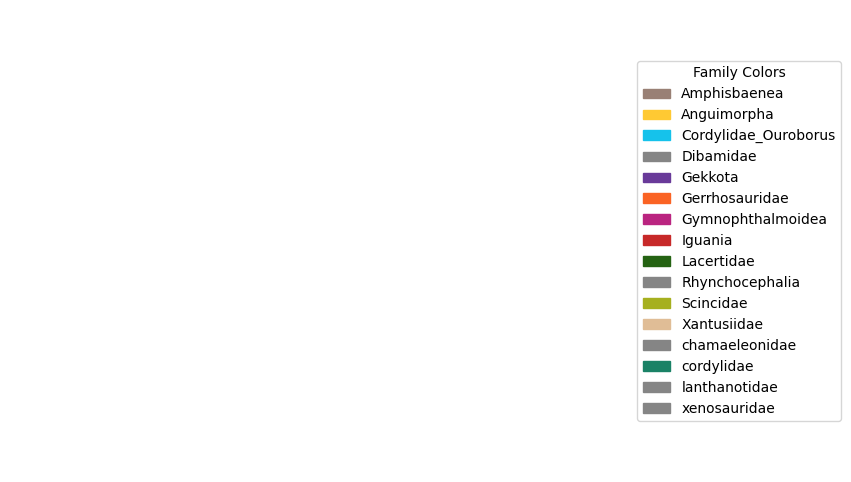

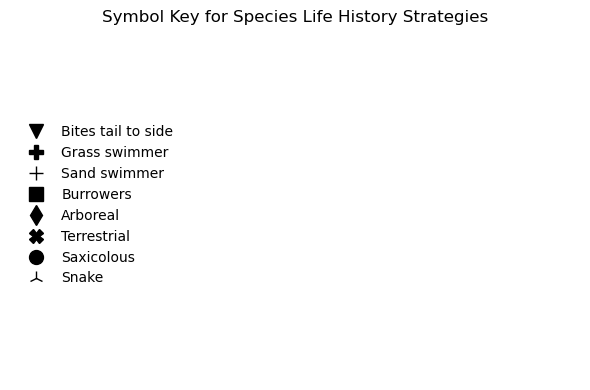

In [7]:
plot_family_color_legend(family_base_colors)

plot_life_history_legend(legend_items)

## Export PC/tSNE/UMAP coords for visualization in R/Excel
---

In [ ]:
# Run PCA to reduce dimensions (using PC1 and PC2 for the scatterplot).
pca = PCA(n_components=4)
pca_coords = pca.fit_transform(codes)

# Group PC1 and PC2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, pca_coords[i, 0], pca_coords[i, 1], pca_coords[i, 2], pca_coords[i, 3]))

# Sort data by species-vertebra pairs and PC1-4
rows = []
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    for vertebra, pc1, pc2, pc3, pc4 in points_sorted:
        rows.append([species, vertebra, pc1, pc2, pc3, pc4])

# Export to csv
df = pd.DataFrame(rows, columns=["Species", "Vertebra", "PC1", "PC2", "PC3", "PC4"])
df.to_csv("pca_points_for_stats.csv", index=False)

# Do the same for UMAP

# Run UMAP to reduce dimensions (using UMAP1 and UMAP2 for the scatterplot).
umap_reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.8, random_state=42)
umap_coords = umap_reducer.fit_transform(codes)

# Group UMAP1 and UMAP2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, umap_coords[i, 0], umap_coords[i, 1]))

# Sort data by species-vertebra pairs and UMAP
rows = []
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    for vertebra, umap1, umap2 in points_sorted:
        rows.append([species, vertebra, umap1, umap2])

# Export to csv
df = pd.DataFrame(rows, columns=["Species", "Vertebra", "UMAP1", "UMAP2"])
df.to_csv("UMAP_points_for_stats.csv", index=False)

# Do the same for tSNE

# Run t-SNE to reduce dimensions
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_coords = tsne.fit_transform(codes)

# Group tsne1 and tsne2 by species, storing the vertebra label.
species_groups = defaultdict(list)
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        species_groups[species].append((vertebra, tsne_coords[i, 0], tsne_coords[i, 1]))

# Sort data by species-vertebra pairs and UMAP
rows = []
for species, points in species_groups.items():
    points_sorted = sorted(points, key=sort_key)
    for vertebra, tsne1, tsne2 in points_sorted:
        rows.append([species, vertebra, tsne1, tsne2])

# Export to csv
df = pd.DataFrame(rows, columns=["Species", "Vertebra", "tSNE1", "tSNE2"])
df.to_csv("tSNE_points_for_stats.csv", index=False)

/home/k.wolcott/anaconda3/envs/NSM/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/k.wolcott/anaconda3/envs/NSM/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
